In [1]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
# from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinnshixu import PINNs
from model.pinnsformer import PINNsformer

import scipy.io
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [3]:
res, t_left = get_time_data([0,60000], 2500) #生成训练数据，t的范围是[0,60000]，共2500个配位点。返回的res形状为(2500,1)，t_left是(1,1)
res_test, _ = get_time_data([0,80000], 5000) #生成测试数据，采样点数为101x101
#这样，res_test是一个形状为(101*101,2)的数组，代表测试数据
u_left = np.array([[1,0,0]])          # 初始真实状态

mu_x, sigma_x = res.mean(0), res.std(0) #计算X_u的均值和标准差
t_left = (t_left - mu_x) / sigma_x #对X_u进行标准化
res = (res - mu_x) / sigma_x #对X_f进行标准化


res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
t_left = torch.tensor(t_left, dtype=torch.float32, requires_grad=True).to(device)
u_left = torch.tensor(u_left, dtype=torch.float32, requires_grad=True).to(device)


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
# Train PINNs 

model = PINNs(in_dim=1, hidden_dim=512, out_dim=3, num_layer=4).to(device)

model.apply(init_weights)
optim = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
optim_Adam = torch.optim.Adam(model.parameters(), eps = 1e-8)

print(model)
print(get_n_params(model))

C:\Users\lcy\AppData\Local\Temp\ipykernel_197256\2908461885.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
527875


In [5]:
# res, b_left, b_right, b_upper, b_lower = get_data([-1,1], [0,1], 101, 101)
# res_test, _, _, _, _ = get_data([-1,1], [0,1], 256, 100) #生成测试数据，采样点数为101x101
# #这样，res_test是一个形状为(101*101,2)的数组，代表测试数据

# res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
# b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
# b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
# b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
# b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

# x_res, t_res = res[:,0:1], res[:,1:2]
# x_left, t_left = b_left[:,0:1], b_left[:,1:2]
# x_right, t_right = b_right[:,0:1], b_right[:,1:2]
# x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
# x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform(m.weight)
#         m.bias.data.fill_(0.01)

In [6]:
loss_track = [] #记录loss

for i in tqdm(range(50000)): #训练500次
    def closure():
        u = model(res) #得到配位点的预测结果
        pred_left = model(t_left) #得到左边界点的预测结果

        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3
        

        u_x_1 = torch.autograd.grad(
            u1, res, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, res, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, res, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / torch.tensor(sigma_x, dtype=torch.float32, requires_grad=False).to(device)
        u_x_2 = u_x_2 / torch.tensor(sigma_x, dtype=torch.float32, requires_grad=False).to(device)
        u_x_3 = u_x_3 / torch.tensor(sigma_x, dtype=torch.float32, requires_grad=False).to(device)
        
        #计算残差
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_res = loss_1 + loss_2 + loss_3
        # residual = residual_1 + residual_2 + residual_3


        loss_ic = torch.mean((u_left - pred_left) ** 2) #计算初值的损失函数

        

        loss_track.append([loss_res.item(), loss_ic.item()])

        loss = loss_res + loss_ic
        optim_Adam.zero_grad()
        loss.backward()
        return loss

    optim_Adam.step(closure)

100%|██████████| 50000/50000 [05:32<00:00, 150.43it/s]



In [7]:
print('Loss Res: {:10f}, Loss_IC: {:10f}'.format(loss_track[-1][0], loss_track[-1][1]))
print('Train Loss: {:10f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinns.pt')

Loss Res:   0.000000, Loss_IC:   0.000000
Train Loss:   0.000001


In [8]:
# Visualize PINNs 
res_test = (res_test - mu_x) / sigma_x #对X_f进行标准化
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)

with torch.no_grad():
    pred = model(res_test)  # 取所有输出列，不只是第0列
    pred = pred.cpu().detach().numpy()

# pred = pred.reshape(100,256).T

#读取真实解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
eigenvector_solution_df.columns = ['state_0', 'state_1', 'state_2']
y_star = eigenvector_solution_df

rl1 = np.sum(np.abs(y_star-pred)) / np.sum(np.abs(y_star))
rl2 = np.sqrt(np.sum((y_star-pred)**2) / np.sum(y_star**2))

rl1 = sum(rl1)/len(rl1)
rl2 = sum(rl2)/len(rl2)

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))



relative L1 error: 22.048053
relative L2 error: 14.412013


In [9]:
np.sum(np.abs(y_star-pred)) / np.sum(np.abs(y_star))

state_0    18.733842
state_1    43.180764
state_2     4.229554
dtype: float64

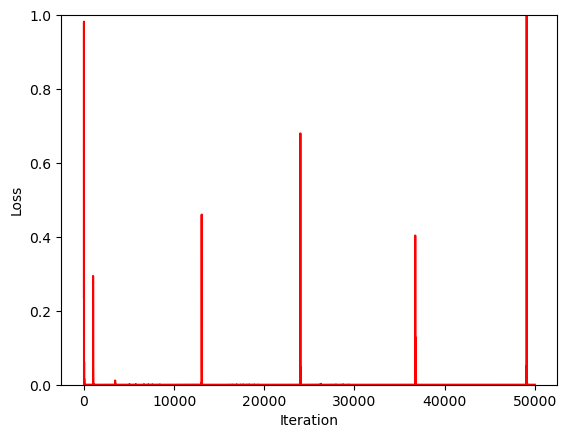

In [10]:
loss = [sum(sublist) for sublist in loss_track]
indices=list(range(len(loss)))
plt.figure()
plt.plot(indices,loss,color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([0,100]) # 设置x轴的范围
plt.ylim([0,1]) # 设置y轴的范围
plt.show()

Text(0, 0.5, 'Probability')

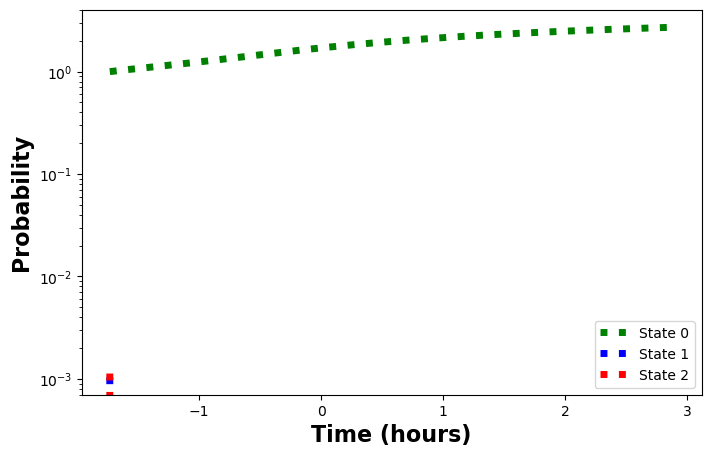

In [11]:
import seaborn as sns  # 导入seaborn库用于绘制密度图
# x_star = res_test.cpu().detach().numpy().flatten()
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = res_test.cpu().detach().numpy().flatten(), y = pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = res_test.cpu().detach().numpy().flatten(), y = pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = res_test.cpu().detach().numpy().flatten(), y = pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

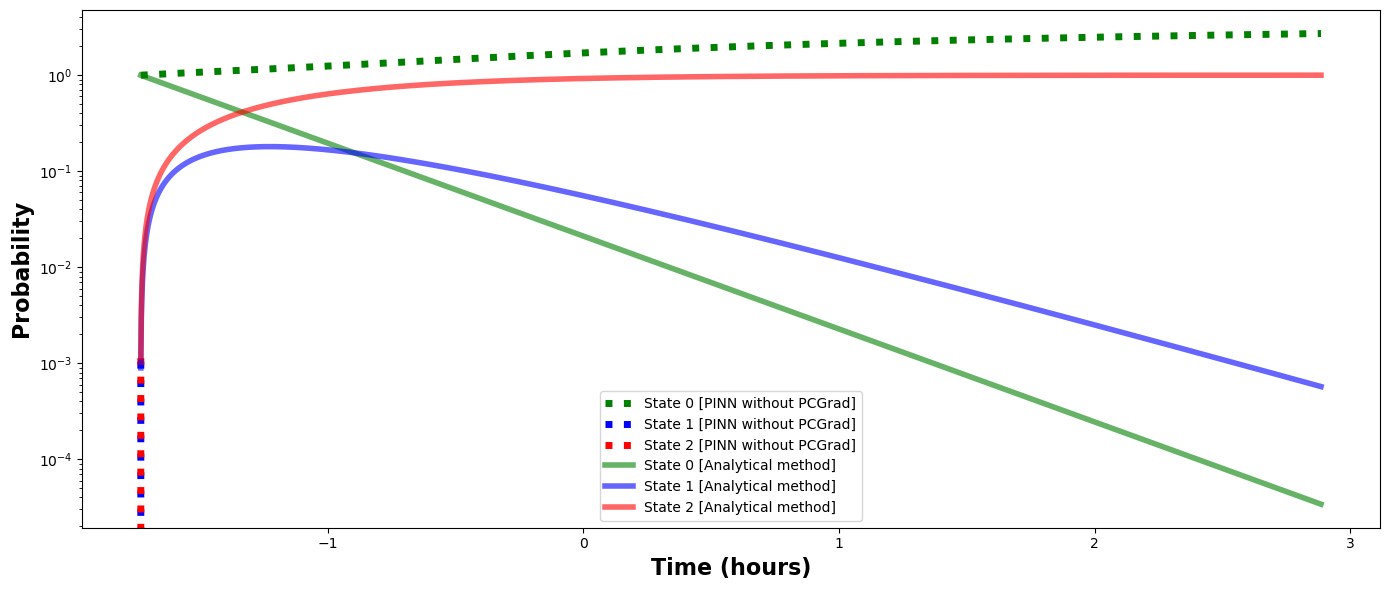

In [12]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=res_test.cpu().detach().numpy().flatten(), y=pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=res_test.cpu().detach().numpy().flatten(), y=pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=res_test.cpu().detach().numpy().flatten(), y=pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=res_test.cpu().detach().numpy().flatten(), y=eigenvector_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=res_test.cpu().detach().numpy().flatten(), y=eigenvector_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=res_test.cpu().detach().numpy().flatten(), y=eigenvector_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()